# New York City Taxi Fare Prediction

The aim is to predict the taxi fare for the customer taking cab service in New York City

#### Data Import and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import seaborn as sb
%matplotlib inline

In [2]:
print(os.listdir('./'))

['.config', 'Anaconda3-5.2.0-Linux-x86_64.sh', 'train.csv', 'anaconda3', '.jupyter', '.bashrc', '.profile', 'KaggleDSF.ipynb', '.bash_logout', 'sample_submission.csv', '.bash_history', 'GCP-Coupons-Instructions.rtf', 'final_result.csv', '.bashrc-anaconda3.bak', '.cache', '.ssh', '.local', '.ipynb_checkpoints', 'test.csv', '.viminfo', '.ipython']


In [3]:
train_df =  pd.read_csv('./train.csv') 
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [4]:
print(train_df.shape[0])

55423856


In [5]:
#Drop any values that are NaN
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

New size: 55423480


In [6]:
#Drop all the rows that have value = 0 in them
train_df = train_df[(train_df != 0).all(1)] 
print('New size: %d' % len(train_df))

New size: 54127059


In [7]:
#Take only those Fares of passengers that have a postive value
train_df = train_df[train_df.fare_amount > 0]
print('New size: %d' % len(train_df))

New size: 54124853


In [8]:
#Using the general fare_amount from the given data set, it seems the fare of more than 175, are outliers
train_df = train_df[train_df.fare_amount < 175]
print('New size: %d' % len(train_df))

New size: 54122340


In [9]:
#We are taking percentile of the data in order to identify the outliers and make sure to remove them 
train_df['pickup_longitude'].quantile([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.95, 0.99, 1])

0.00   -3442.059565
0.01     -74.014384
0.05     -74.006905
0.10     -74.002911
0.20     -73.994792
0.30     -73.990328
0.40     -73.986191
0.50     -73.982087
0.60     -73.977850
0.70     -73.972158
0.80     -73.963565
0.90     -73.953194
0.95     -73.934200
0.99     -73.785999
1.00    3457.625683
Name: pickup_longitude, dtype: float64

* From the above values we can see that the majority of data lies between 1%tile and 99%tile. So we are now going to filter the data according to their percentile ranges   

In [10]:
print('Size of training data: %d' % len(train_df) )

train_df = train_df[(train_df['pickup_longitude'] <= train_df['pickup_longitude'].quantile(0.999)) ]
train_df = train_df[(train_df['pickup_longitude'] >= train_df['pickup_longitude'].quantile(0.005))]

train_df = train_df[(train_df['pickup_latitude'] <= train_df['pickup_latitude'].quantile(0.999)) ]
train_df = train_df[(train_df['pickup_latitude'] >= train_df['pickup_latitude'].quantile(0.005))]

train_df = train_df[(train_df['dropoff_longitude'] <= train_df['dropoff_longitude'].quantile(0.999)) ]
train_df = train_df[(train_df['dropoff_longitude'] >= train_df['dropoff_longitude'].quantile(0.005))]

train_df = train_df[(train_df['dropoff_latitude'] <= train_df['dropoff_latitude'].quantile(0.999)) ]
train_df = train_df[(train_df['dropoff_latitude'] >= train_df['dropoff_latitude'].quantile(0.005))]

print('New size: %d' % len(train_df))

Size of training data: 54122340
New size: 52852731


##### We tried taking different values of the percentile, and taking the data between 0.5%tile and 99.9%tile gives us the best data set for training. 

In [11]:
eu_cal = (train_df['dropoff_latitude'] - train_df['pickup_latitude']) **2  + (train_df['dropoff_longitude'] - train_df['pickup_longitude']) **2

eu_dist = np.sqrt(eu_cal)


### Pearson Correlation between Eucledian Distance and Fare Amount

In [12]:
eu_dist.corr(train_df['fare_amount'])

0.8806340289981661

In [13]:
#Get the given pickup time in a new format of date of Y-M-D:H-M-S
train_df['pickup_datetime'] = train_df['pickup_datetime'].str.replace(" UTC", "")
#replace the given date time in a new format
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [14]:
journey_time = (train_df['pickup_datetime'].dt.hour)*60 + train_df['pickup_datetime'].dt.minute

### Pearson Correlation between Eucledian Distance and the Time

In [15]:
eu_dist.corr(journey_time)

-0.032817644627646574

### Pearson Correlation between Fare Amount and the Time

In [16]:
journey_time.corr(train_df['fare_amount'])

-0.01736950684640317

In [17]:
train_df['distance'] = eu_dist
train_df['journey_time'] = journey_time

### Plot between Distance and Total Fare Amount

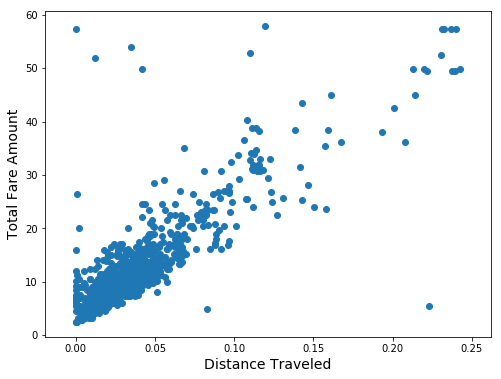

In [18]:
plt.figure(figsize = (8,6))
plt.xlabel('Distance Traveled', fontsize = 14)
plt.ylabel('Total Fare Amount', fontsize = 14)
plt.scatter(train_df[:1200].distance, train_df[:1200].fare_amount)
plt.show()

* The plot between Distance traveled and the Total Fare Amount generates a linear relationship

### Plot between Distance and Time

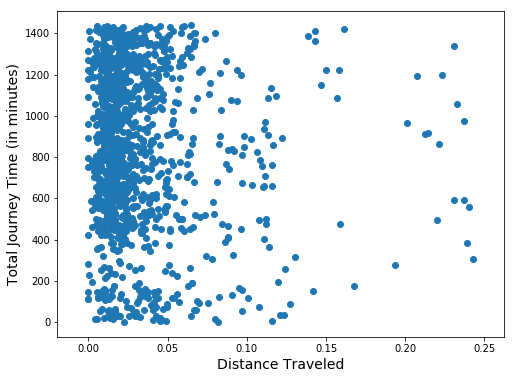

In [19]:
plt.figure(figsize = (8,6))
plt.xlabel('Distance Traveled', fontsize = 14)
plt.ylabel('Total Journey Time (in minutes)', fontsize = 14)
plt.scatter(train_df[:1200].distance, train_df[:1200].journey_time)
plt.show()

* The plot between Distance traveled and the total journey time of a passenger generates a non - linear relationship. This plot doesn't tell us the exact relationship between the variables

### Plot between Total Fare Amount and Time

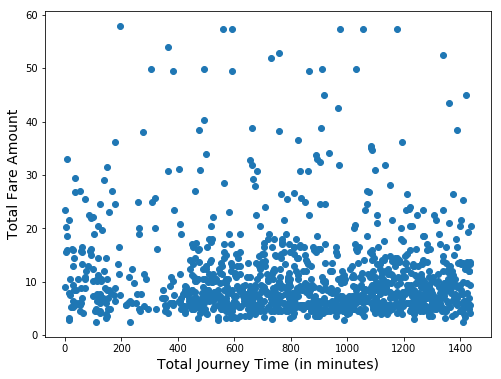

In [20]:
plt.figure(figsize = (8,6))
plt.xlabel('Total Journey Time (in minutes)', fontsize = 14)
plt.ylabel('Total Fare Amount', fontsize = 14)
plt.scatter(train_df[:1200].journey_time, train_df[:1200].fare_amount)
plt.show()

* The plot between Distance traveled and the total journey time of a passenger generates a non - linear relationship. The plot gives a scattered data and hence we cannot infer anything from it

### Plot between Total Fare Amount and Total Passenger Count

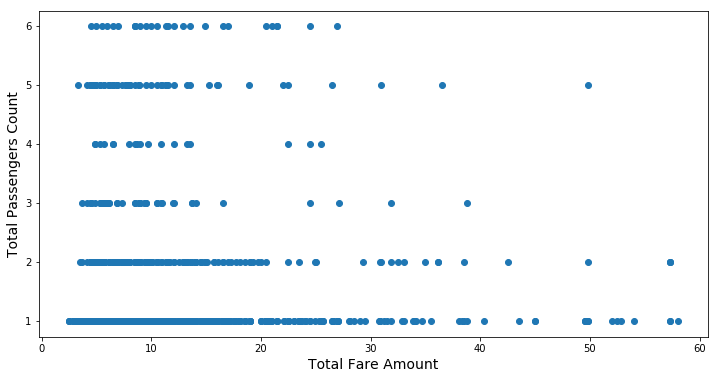

In [22]:
plt.figure(figsize = (12,6))
plt.xlabel('Total Fare Amount', fontsize = 14)
plt.ylabel('Total Passengers Count', fontsize = 14)
plt.scatter(train_df[:1200].fare_amount, train_df[:1200].passenger_count)
plt.show()

* The plot between total fare and the number of passengers taking the cab, we see that generally people in New York City are spending less than 30$ while they take the cab service, although it is a very generic statement

### Bar Chart comparing the fare amount depending on the hour of the day

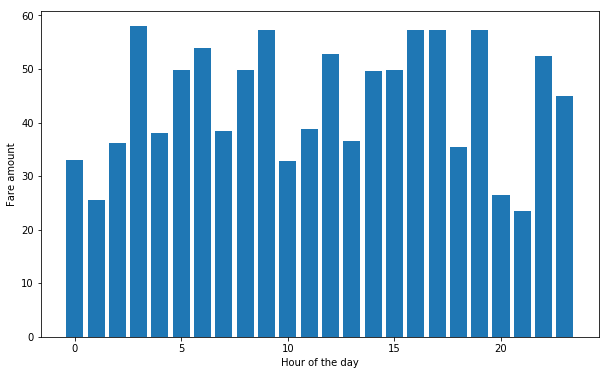

In [23]:
pickup_hour_time = (train_df['pickup_datetime'].dt.hour)[:1200]
fare = train_df[:1200].fare_amount

plt.figure(figsize = (10,6))
plt.bar(pickup_hour_time, fare)
plt.xlabel('Hour of the day')
plt.ylabel('Fare amount')
plt.show()

* This plot shows relationship between the fare amount at particular hours of the day. We can see at what times during the day, we have highest amount of fare. It seems that during early morning hours(3 AM, 9 AM), and the evening at 5PM, 6PM and 8 PM we are able to see the highest fare amount throughout the day. 

### Data plot based on Pickup locations 

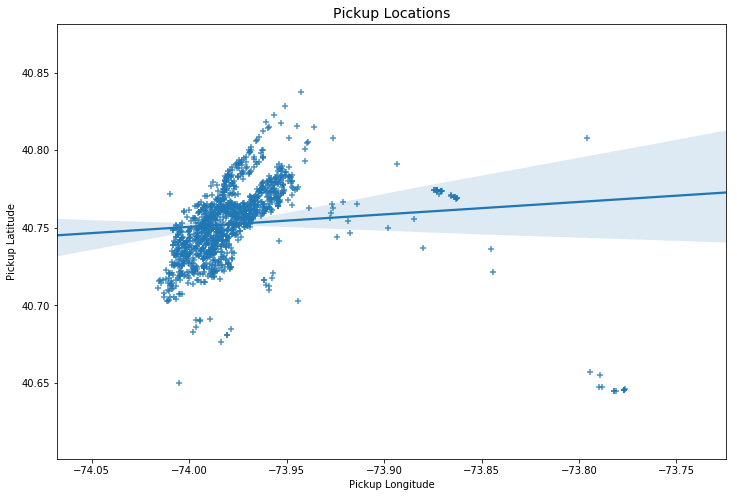

In [24]:
plt.figure(figsize = (12,8))
plt.title('Pickup Locations', fontsize=14)
p_long, p_lat = pd.Series(train_df[:1200].pickup_longitude, name="Pickup Longitude"), pd.Series(train_df[:1200].pickup_latitude, name="Pickup Latitude")
pickup = sb.regplot(x=p_long, y=p_lat, marker="+")

* From the given plot we get to know the various locations of pickups based on their latitude and longitude coordinates. Since we have a huge datasset, we can see the whole map of New York City from the marking locations of pickup. We can also see there are a few points for the pickup in the right bottom corner, because those coordinates are of JFK airport, while a few scattered points are also present which represent the pickup locations in the New York's boroughs as well. So we can take the pickup based on these locations as well.

### Data plot based on DropOff locations 

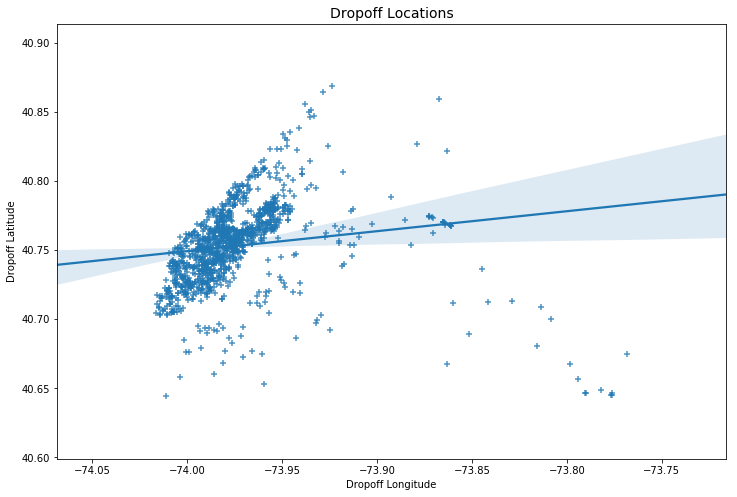

In [25]:
plt.figure(figsize = (12,8))
plt.title('Dropoff Locations', fontsize=14)
d_long, d_lat = pd.Series(train_df[:1200].dropoff_longitude, name="Dropoff Longitude"), pd.Series(train_df[:1200].dropoff_latitude, name="Dropoff Latitude")
dropoff = sb.regplot(x=d_long, y=d_lat, marker="+")

* From the given plot we get to know the various locations of dropoff points based on their latitude and longitude coordinates. We can see the map of New York City from the marking locations of dropoff. We can also see there are a few points for the pickup in the right bottom corner, because those coordinates are of JFK airport. Here we see a lot of scattered points across Manhattan, so we can say that, many of the taxi cab's customers have a drop off location outside of New York City.

### Addtional Feature Extraction

In [26]:
train_df['day'] = train_df['pickup_datetime'].dt.day;
train_df['month'] = train_df['pickup_datetime'].dt.month;
train_df['hour'] = train_df['pickup_datetime'].dt.hour;
train_df['minute'] = train_df['pickup_datetime'].dt.minute;
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,journey_time,day,month,hour,minute
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,1046,15,6,17,26
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,35,18,8,0,35
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,270,21,4,4,30
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,471,9,3,7,51
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,0.038675,590,6,1,9,50


### Data Training - Linear Regression

In [27]:
data2 = train_df[:5000000]

features = ['passenger_count', 'distance','journey_time']
X = data2[features]
y = data2['fare_amount']

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)

/home/jaytorasakar8/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(4000000, 3) (1000000, 3) (4000000,) (1000000,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
print(lr.intercept_)
print(lr.coef_)
zip(features, lr.coef_)

3.681485743096034
[3.83209484e-02 2.14108053e+02 2.33985391e-04]


In [29]:
y_pred = lr.predict(X_test)
print(y_pred)
print("RMS: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[ 7.30657215 54.23850427 12.23251382 ... 10.38259487 13.18943025
 10.87297067]
RMS:  3.9125811581058527


#### We are getting RMS value =  3.912 from the training data set 

### Actual Data Prediction using Training Data Set

In [30]:
actual_data =  pd.read_csv('./test.csv') 
actual_data.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [31]:
eu_cal = (actual_data['dropoff_latitude'] - actual_data['pickup_latitude']) **2  + (actual_data['dropoff_longitude'] - actual_data['pickup_longitude']) **2

eu_dist = np.sqrt(eu_cal)


In [32]:
actual_data['pickup_datetime'] = actual_data['pickup_datetime'].str.replace(" UTC", "")
#replace the given date time in a new format
actual_data['pickup_datetime'] = pd.to_datetime(actual_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')


In [33]:
journey_time = (actual_data['pickup_datetime'].dt.hour)*60 + actual_data['pickup_datetime'].dt.minute

In [34]:
actual_data['distance'] = eu_dist
actual_data['journey_time'] = journey_time

In [35]:
actual_data['day'] = actual_data['pickup_datetime'].dt.day;
actual_data['month'] = actual_data['pickup_datetime'].dt.month;
actual_data['hour'] = actual_data['pickup_datetime'].dt.hour;
actual_data['minute'] = actual_data['pickup_datetime'].dt.minute;
actual_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,journey_time,day,month,hour,minute
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,0.021554,788,27,1,13,8
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,0.023180,788,27,1,13,8
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.005870,713,8,10,11,53
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,0.018649,1272,1,12,21,12
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,0.050631,1272,1,12,21,12


In [36]:
features1 = ['passenger_count', 'distance','journey_time']
X1 = actual_data[features1]

In [37]:
predict_value = lr.predict(X1)
print(predict_value)

[ 8.51905451  8.86716494  5.14353718 ... 50.66078921 21.25225034
  6.9565911 ]


In [38]:
final_data = pd.DataFrame()
final_data['key'] = actual_data['key']
final_data['fare_amount'] = predict_value
final_data.to_csv('final_result.csv',sep=',', index = False)